Image Classification using AWS Sagemaker [Dog Breed]

Thiviyaa S
24-01-2022


In [19]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [20]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
from sagemaker.session import Session
from sagemaker import get_execution_role

role=get_execution_role()
sagemaker_session=sagemaker.Session()
region=sagemaker_session.boto_region_name
bucket=sagemaker_session.default_bucket()
print(f"region:{region}")
print(f"bucket:{bucket}")


region:us-east-1
bucket:sagemaker-us-east-1-698821211110


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [21]:
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip 
!unzip -f dogImages.zip 

--2022-01-24 13:19:23--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.112.64
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.112.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  10.2MB/s    in 76s     

2022-01-24 13:20:42 (14.2 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip


In [23]:
prefix ="dogImagesDataset"
print("Starting to uploading dogImages")

inputs = sagemaker_session.upload_data(path="dogImages", bucket=bucket, key_prefix=prefix)
print(f"Input path ( S3 file path ): {inputs}")

Starting to uploading dogImages
Input path ( S3 file path ): s3://sagemaker-us-east-1-698821211110/dogImagesDataset


In [28]:
inputs = 's3://sagemaker-us-east-1-698821211110/dogImagesDataset/'
print(f"Input path ( S3 file path): {inputs}")

Input path ( S3 file path): s3://sagemaker-us-east-1-698821211110/dogImagesDataset/


## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [29]:
from sagemaker.tuner import(
CategoricalParameter,
ContinuousParameter,
HyperparameterTuner)

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.0001, 0.1),
    "eps": ContinuousParameter(1e-9, 1e-8),
    "weight_decay": ContinuousParameter(1e-3, 1e-1),
    "batch_size": CategoricalParameter([ 64, 128]),
}
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]


In [30]:
from sagemaker.pytorch import PyTorch


estimator = PyTorch(
entry_point="hpo.py",
base_job_name="classification",
role=role,
instance_count=1,
instance_type = "ml.g4dn.xlarge",
py_version = "py36",
framework_version = "1.8"
)

tuner = HyperparameterTuner(
estimator,
objective_metric_name,
hyperparameter_ranges,
metric_definitions,
max_jobs=4,
max_parallel_jobs=2,
objective_type=objective_type, 
early_stopping_type="Auto"
)

In [31]:

tuner.fit({"training":inputs},wait=True)

...................................................................................................................................................................................................................................................................................................................................!


In [32]:


best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-01-24 13:50:12 Starting - Preparing the instances for training
2022-01-24 13:50:12 Downloading - Downloading input data
2022-01-24 13:50:12 Training - Training image download completed. Training in progress.
2022-01-24 13:50:12 Uploading - Uploading generated training model
2022-01-24 13:50:12 Completed - Training job completed


{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"128"',
 'eps': '1.598855182345577e-09',
 'lr': '0.00043270131115326176',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"classification-2022-01-24-13-25-11-297"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-698821211110/classification-2022-01-24-13-25-11-297/source/sourcedir.tar.gz"',
 'weight_decay': '0.0019063995719784189'}

In [33]:
#printing out the best hyper-parameters
best_hyperparameters={'batch_size':int(best_estimator.hyperparameters()['batch_size'].replace('"',"")),
'eps':best_estimator.hyperparameters()['eps'],
'lr':best_estimator.hyperparameters()['lr'],
'weight_decay': best_estimator.hyperparameters()['weight_decay'],}
print(f"Best Hyperparamters after hyper-paramter fine tuning are: \n {best_hyperparameters}")

Best Hyperparamters after hyper-paramter fine tuning are: 
 {'batch_size': 128, 'eps': '1.598855182345577e-09', 'lr': '0.00043270131115326176', 'weight_decay': '0.0019063995719784189'}


## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [34]:
from sagemaker.debugger import(
Rule,
rule_configs,
ProfilerRule,
DebuggerHookConfig,
# CollectionConfig,
ProfilerConfig,
FrameworkProfile)

rules=[
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]


profiler_config=ProfilerConfig(
system_monitor_interval_millis=500,framework_profile_params=FrameworkProfile(num_steps=10))
debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)



In [35]:
# TODO: Create and fit an estimator

estimator = PyTorch(
entry_point="train_model.py",
instance_count=1,
instance_type="ml.g4dn.xlarge",
role=role,
framework_version="1.6", 
py_version="py36",
hyperparameters=best_hyperparameters,
profiler_config=profiler_config,
debugger_hook_config=debugger_config, 
rules=rules
)

estimator.fit({'train' : inputs },wait=True)

2022-01-24 13:53:31 Starting - Starting the training job...
2022-01-24 13:53:57 Starting - Launching requested ML instancesVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2022-01-24 13:54:57 Starting - Preparing the instances for training......
2022-01-24 13:55:57 Downloading - Downloading input data............
2022-01-24 13:57:58 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-01-24 13:58:08,006 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-01-24 13:58:08,027 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-01-24 13:58:08,034 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-01-24 13:58:08,383 sagemaker-training-toolkit INFO     Invoking user script
Tra

In [36]:
#fetching jobname , client and description to be used for plotting.
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

print(f"Job name:{job_name}")
print(f"client:{client}")
print(f"description:{description}")

Job name:pytorch-training-2022-01-24-13-53-30-631
client:<botocore.client.SageMaker object at 0x7f30428897d0>
description:{'TrainingJobName': 'pytorch-training-2022-01-24-13-53-30-631', 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:698821211110:training-job/pytorch-training-2022-01-24-13-53-30-631', 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-698821211110/pytorch-training-2022-01-24-13-53-30-631/output/model.tar.gz'}, 'TrainingJobStatus': 'Completed', 'SecondaryStatus': 'Completed', 'HyperParameters': {'batch_size': '128', 'eps': '"1.598855182345577e-09"', 'lr': '"0.00043270131115326176"', 'sagemaker_container_log_level': '20', 'sagemaker_job_name': '"pytorch-training-2022-01-24-13-53-30-631"', 'sagemaker_program': '"train_model.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-698821211110/pytorch-training-2022-01-24-13-53-30-631/source/sourcedir.tar.gz"', 'weight_decay': '"0.0019063995719784189"'}, 'AlgorithmSpecif

In [37]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
trial = create_trial(estimator.latest_job_debugger_artifacts_path())


[2022-01-24 14:04:27.998 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:19 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-01-24 14:04:28.033 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:19 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-698821211110/pytorch-training-2022-01-24-13-53-30-631/debug-output


In [38]:
trial.tensor_names()

[2022-01-24 14:05:47.006 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:19 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-01-24 14:05:48.033 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:19 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.bias',
 'gradient/ResNet_fc.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.relu_input_2',
 'layer3.4.relu_input_0',
 'layer3.4.relu_input_1',
 '

In [39]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))


2

In [40]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))

2

In [41]:
#Defining some utility functions to be used for plotting tensors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

#utility function to get data from tensors
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("Completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("Completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)
    plt.show()

loaded TRAIN data
loaded EVAL data
Completed TRAIN plot
Completed EVAL plot


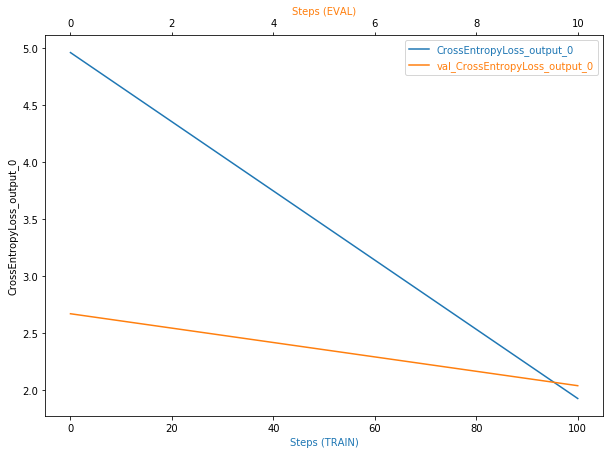

In [42]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

In [43]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"Profiler report location: {rule_output_path}")

Profiler report location: s3://sagemaker-us-east-1-698821211110/pytorch-training-2022-01-24-13-53-30-631/rule-output


In [44]:
! aws s3 ls {rule_output_path} --recursive

2022-01-24 14:03:44     370438 pytorch-training-2022-01-24-13-53-30-631/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-01-24 14:03:44     218752 pytorch-training-2022-01-24-13-53-30-631/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-01-24 14:03:38        191 pytorch-training-2022-01-24-13-53-30-631/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-01-24 14:03:38      17979 pytorch-training-2022-01-24-13-53-30-631/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-01-24 14:03:38        126 pytorch-training-2022-01-24-13-53-30-631/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-01-24 14:03:38        129 pytorch-training-2022-01-24-13-53-30-631/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-01-24 14:03:38       5228 pytorch-training-2022-01-24-13-53-30-631/rule-output/ProfilerReport/profiler-output/profiler-re

In [45]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-698821211110/pytorch-training-2022-01-24-13-53-30-631/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-698821211110/pytorch-training-2022-01-24-13-53-30-631/rule-output/ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json to ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json
download: s3://sagemaker-us-east-1-698821211110/pytorch-training-2022-01-24-13-53-30-631/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-698821211110/pytorch-training-2022-01-24-13-53-30-631/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-69882121111

In [46]:
import os


profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [47]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

In [48]:
import shutil
shutil.make_archive("./profiler_repot.zip", "zip", "ProfilerReport")

'/root/Deep learning/profiler_repot.zip.zip'

## Model Deploying

In [49]:
# TODO: Deploy your model to an endpoint

predictor=estimator.deploy(initial_instance_count=1, instance_type="ml.m5.xlarge") 


------!

In [50]:
model_data = estimator.output_path + estimator.latest_training_job.job_name + "/output/model.tar.gz"
print(f"Model: {model_data}")

Model: s3://sagemaker-us-east-1-698821211110/pytorch-training-2022-01-24-13-53-30-631/output/model.tar.gz


In [52]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImgPredictor(Predictor):
    def __init__( self, endpoint_name, sagemaker_session):
        super( ImgPredictor, self).__init__(
            endpoint_name,
            sagemaker_session = sagemaker_session,
            serializer = jpeg_serializer,
            deserializer = json_deserializer
        )
        
pytorch_model = PyTorchModel( model_data = model_data,
                            role = role,
                            entry_point= "inference.py",
                            py_version = "py36",
                            framework_version = "1.6",
                             predictor_cls = ImgPredictor
                            )

predictor = pytorch_model.deploy( initial_instance_count = 1, instance_type = "ml.t2.medium")

-------------------------------!

Test image no: 1
Below is the image that we will be testing:


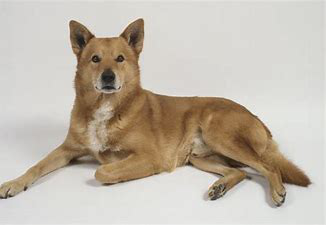

Expected dog breed category no : 129
Response: [[-4.196916103363037, -2.370950222015381, -1.927738070487976, -0.8184378147125244, -1.5287636518478394, -2.540006399154663, -3.0017030239105225, -2.2938404083251953, -3.3382582664489746, -0.8149749636650085, -1.84967839717865, -3.8393499851226807, -2.427314281463623, -1.1117714643478394, -2.9025027751922607, -3.881228446960449, -3.951944351196289, -2.003580331802368, -3.472930908203125, -0.12886962294578552, -1.7123390436172485, -0.25577014684677124, -3.7018535137176514, -4.91478967666626, -3.7881100177764893, -4.2596259117126465, -1.6366056203842163, -3.4633827209472656, -3.8665034770965576, -1.8954241275787354, -3.1482534408569336, -4.0884013175964355, -3.7234396934509277, -2.940768241882324, -3.617140293121338, -3.5114428997039795, -3.349393367767334, -3.0555455684661865, -2.5786354541778564, -4.23938512802124, -2.405543088912964, -2.8097610473632812, -0.5829309821128845, -2.5231685638427734, -2.030524969100952, -5.679047584533691, -1.1

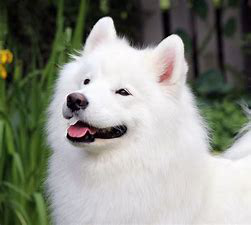

Expected dog breed category no : 5
Response: [[-3.7760009765625, -3.1466143131256104, -4.349684238433838, -0.12458072602748871, 0.3848133981227875, 4.073222637176514, -5.370388031005859, -4.030537128448486, -4.040594577789307, -3.314150094985962, -3.507317304611206, -3.1024882793426514, -2.900848388671875, -3.888049602508545, -4.540744304656982, -5.434025287628174, -3.399540424346924, -3.3913629055023193, -3.73644757270813, -4.381100177764893, -0.7667586207389832, -1.2908201217651367, -3.8015494346618652, -1.2532240152359009, -5.2079925537109375, -4.485209941864014, -5.056806564331055, -4.821657657623291, -2.4498589038848877, -3.854661703109741, -2.847416400909424, -5.0692219734191895, -3.2930469512939453, -5.137305736541748, -4.052058219909668, -3.870548725128174, -3.6378839015960693, -3.252185821533203, -2.9455454349517822, -4.3808274269104, -5.019869804382324, -2.342987298965454, -1.529425024986267, -4.676707744598389, -2.942281484603882, -4.260156154632568, -4.987652778625488, -3.3

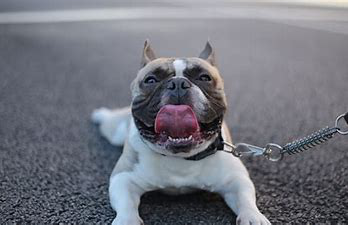

Expected dog breed category no : 21
Response: [[-3.3927388191223145, -5.46068811416626, -3.7092485427856445, -1.9216749668121338, -2.4011826515197754, -2.710526704788208, -3.4283409118652344, -2.1957786083221436, -4.1347270011901855, -2.744370698928833, -3.089491128921509, -4.697192192077637, -4.492753982543945, -3.048901081085205, -2.6609790325164795, -3.51353120803833, -4.220621109008789, -4.082894325256348, -3.395481824874878, -4.477132797241211, -4.853475093841553, -4.073809623718262, -3.9698314666748047, -2.680436372756958, -4.933744430541992, -4.9092559814453125, -5.119359493255615, -3.440397024154663, -4.259000778198242, -2.694927453994751, -5.077439785003662, -0.31691306829452515, -4.155894756317139, -1.99952232837677, -3.8073315620422363, -4.242248058319092, -3.314371347427368, -2.1845903396606445, -0.6010990738868713, 0.09257242828607559, -1.8741899728775024, -2.929675579071045, -2.955958843231201, -2.044461250305176, -3.077874183654785, -3.4331812858581543, -4.80870056152343

In [54]:
from PIL import Image
import io
import os
import numpy as np

test_dir = "./testImages"
test_images = [ 'dog1.jpg', 'dog2.jpg', 'dog3.jpg' ]
test_images_expected_output = [129, 5, 21 ]
for index in range(len(test_images) ):
    test_img = test_images[index]
    expected_breed_category = test_images_expected_output[index]
    print(f"Test image no: {index+1}")
    test_file_path = os.path.join(test_dir,test_img)
    with open(test_file_path , "rb") as f:
        payload = f.read()
        print("Below is the image that we will be testing:")
        display(Image.open(io.BytesIO(payload)))
        print(f"Expected dog breed category no : {expected_breed_category}")
        response = predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})
        print(f"Response: {response}")
        predicted_dog_breed = np.argmax(response,1) + 1 #We need to do plus 1 as index starts from zero and prediction is zero-indexed
        print(f"Response/Inference for the above image is : {predicted_dog_breed}")

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()